# CNN   small datasets 학습


- 학습할 Data의 개수가 많지 않을 때 CNN을 통한 모형 학습이 어려울 수 있음
  - 딥러닝은 많은 수의 데이터를 통해 feature engineering 과정 없이 원하는 문제를 해결할 수 있다. => **Point: 많은 데이터 수**
- Data가 많지 않아 CNN 학습에 어려움이 있을 때 사용 가능한 방법
    - Data augmentation 활용
        - 원본 이미지의 색깔, 각도 등을 약간씩 변형한 이미지들을 추가로 만들어 data의 수를 늘림 
    - Pre-trained network의 활용
        - 매우 큰 데이터셋으로 미리 Training한 모델의 파라미터(가중치)를 가져와서 풀려는 문제에 맞게 모델을 재보정해서 사용한다.
        - 성능이 좋은 학습된 모델을 사용하므로 적은 데이터에도 좋은 성능을 낼 수있다.

## Data for cats vs. dogs
- 2013년 Kaggle의 computer vision competition data 활용 https://www.kaggle.com/c/dogs-vs-cats/data
- 개와 고양이를 구분하기 위한 문제로 각 12,500개의 이미지를 포함
- Medium-resolution color JPEGs
- 25000장의 사진 중 4000장의 cats/dogs 사진(2000 cats, 2000 dogs) 만을 사용하여 학습하여 좋은 모형을 만들어 낼 수 있을까?
    - 학습: 2000, 검증: 1000, 테스트: 1000
    
![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)

##### 이미지 다운로드
- gdown 패키지 : 구글 드라이브의 공유파일 다운로드 패키지    
- `pip install gdown`
- 코랩에는 설치 되어 있음.

In [ ]:
from google.colab import drive
drive.mount('/content/colab')

Mounted at /content/colab


In [ ]:
!pip install gdown --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [ ]:
import gdown
from zipfile import ZipFile
import os

def down_extrack():
  url = 'https://drive.google.com/uc?id=1nBE3N2cXQGwD8JaD0JZ2LmFD-n3D5hVU'
  fname = 'cats_and_dogs_small.zip' # 다운받아서 저장할 파일 이름
  # 다운로드
  gdown.download(url, fname, quiet=False)
  # 압축풀기
  with ZipFile(fname) as zipFile: # 압축파일의 경로를 넣어서 ZipFile 객체 생성
    zipFile.extractall('data/cats_and_dogs_small') # 압축 풀 디렉토리 넣어서 실행.

In [ ]:
down_extrack()

Downloading...
From: https://drive.google.com/uc?id=1nBE3N2cXQGwD8JaD0JZ2LmFD-n3D5hVU
To: /content/cats_and_dogs_small.zip
100%|██████████| 90.8M/90.8M [00:00<00:00, 210MB/s]


# 하이퍼파라미터 정의

In [ ]:
LEARNING_RATE = 0.001
N_EPOCH = 200
N_BATCH = 100

## 모델 구현 및 학습

- Input: $224 \times 224$ 픽셀의 RGB layer 
- Output: cat or dog (binary classification)  
- ImageDataGenerator를 이용해 파일시스템에 저장된 이미지 데이터셋을 학습시킨다.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import random

random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

In [ ]:
from keras.api._v2.keras import activations
# 모델 생성
def get_model():
  model = keras.Sequential()

  model.add(layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape=(224, 224, 3)))
  model.add(layers.MaxPooling2D(padding='same'))

  model.add(layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
  model.add(layers.MaxPooling2D(padding='same'))

  model.add(layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
  model.add(layers.MaxPooling2D(padding='same'))

  model.add(layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
  model.add(layers.MaxPooling2D(padding='same'))

  model.add(layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
  model.add(layers.MaxPooling2D(padding='same'))

  model.add(layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
  model.add(layers.MaxPooling2D(padding='same'))

  model.add(layers.Flatten())
  model.add(layers.Dropout(rate=0.5))
  # model.add(layers.Dense(units=2, activation='softmax', name='multi_classification')) # 다중 분류 - loss=categorical_crossentropy
  model.add(layers.Dense(units=1, activation='sigmoid', name='binary_classification_output')) # 이진 분류

  model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
                loss='binary_crossentropy', metrics=['accuracy'])
  
  return model

# ImageDataGenerator 생성

In [ ]:
# 데이터셋 디렉토리 경로
trainset_dir = 'data/cats_and_dogs_small/train/'
valset_dir = 'data/cats_and_dogs_small/validation/'
testset_dir = 'data/cats_and_dogs_small/test/'

In [ ]:
# image augmentation 미적용
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# iterator 생성 -> raw 파일과 역경
train_iter = train_datagen.flow_from_directory(trainset_dir, # Image File 들이 저장된 경로
                                         target_size=(224, 224), # 이미지를 읽어오면서 resize할 크기 (height, width)
                                         class_mode='binary', # output(y) 처리 방식
                                         batch_size=N_BATCH # 배치 size 지정
                                         )

val_iter = val_datagen.flow_from_directory(valset_dir, target_size=(224, 224), class_mode='binary', batch_size=N_BATCH)
test_iter = test_datagen.flow_from_directory(testset_dir, target_size=(224, 224), class_mode='binary', batch_size=N_BATCH)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
train_iter.class_indices # Label 확인

{'cats': 0, 'dogs': 1}

In [ ]:
print('에폭당 step 수')
print(len(train_iter), len(val_iter), len(test_iter))

에폭당 step 수
20 10 10


In [ ]:
v = next(train_iter)
print(type(v)) # (image, label)
print(v[0].shape) # X(image) - (100, 224, 224, 3) (batch수, (224, 224, 3) -> 이미지 한장의 크기기)
print(v[1].shape) # y(label)

<class 'tuple'>
(100, 224, 224, 3)
(100,)


In [ ]:
v[1][:10]

array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)


##  Model Training(학습)

In [ ]:
g_drive_path = '/content/colab/MyDrive/Colab Notebooks/PlayData/07. Deep Learning'
save_dir_path = os.path.join(g_drive_path, 'saved_model', 'cat_dog_model_no_aug')
os.makedirs(save_dir_path, exist_ok=True)

save_weight_path = os.path.join(save_dir_path, 'ckpt')

mc_callback = keras.callbacks.ModelCheckpoint(filepath=save_weight_path,
                                              save_wieghts_only=True, # 파라미터만 저장
                                              save_best_only=True, # 성능이 개선된 애폭것만 저장
                                              monitor='val_loss', verbose=1)
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)

In [ ]:
model = get_model()
hist = model.fit(train_iter,
                 epochs=N_EPOCH,
                 steps_per_epoch = len(train_iter), # 1에폭당 step수
                 validation_data=val_iter,
                 validation_steps=len(val_iter), # 1에폭당 step수
                 callbacks=[mc_callback, es_callback])

Epoch 1/200
20/20 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.5015
Epoch 1: val_loss improved from inf to 0.69116, saving model to /content/colab/MyDrive/Colab Notebooks/PlayData/07. Deep Learning/saved_model/cat_dog_model_no_aug/ckpt


20/20 [==============================] - 30s 777ms/step - loss: 0.6934 - accuracy: 0.5015 - val_loss: 0.6912 - val_accuracy: 0.6120
Epoch 2/200
20/20 [==============================] - ETA: 0s - loss: 0.6855 - accuracy: 0.5495
Epoch 2: val_loss improved from 0.69116 to 0.66229, saving model to /content/colab/MyDrive/Colab Notebooks/PlayData/07. Deep Learning/saved_model/cat_dog_model_no_aug/ckpt


20/20 [==============================] - 16s 800ms/step - loss: 0.6855 - accuracy: 0.5495 - val_loss: 0.6623 - val_accuracy: 0.5400
Epoch 3/200
20/20 [==============================] - ETA: 0s - loss: 0.6483 - accuracy: 0.6255
Epoch 3: val_loss improved from 0.66229 to 0.65143, saving model to /content/colab/MyDrive/Colab Notebooks/PlayData/07. Deep Learning/saved_model/cat_dog_model_no_aug/ckpt


20/20 [==============================] - 15s 745ms/step - loss: 0.6483 - accuracy: 0.6255 - val_loss: 0.6514 - val_accuracy: 0.6260
Epoch 4/200
20/20 [==============================] - ETA: 0s - loss: 0.6207 - accuracy: 0.6525
Epoch 4: val_loss improved from 0.65143 to 0.60361, saving model to /content/colab/MyDrive/Colab Notebooks/PlayData/07. Deep Learning/saved_model/cat_dog_model_no_aug/ckpt


20/20 [==============================] - 15s 746ms/step - loss: 0.6207 - accuracy: 0.6525 - val_loss: 0.6036 - val_accuracy: 0.6730
Epoch 5/200
20/20 [==============================] - ETA: 0s - loss: 0.6090 - accuracy: 0.6540
Epoch 5: val_loss did not improve from 0.60361
20/20 [==============================] - 13s 673ms/step - loss: 0.6090 - accuracy: 0.6540 - val_loss: 0.6453 - val_accuracy: 0.6120
Epoch 6/200
20/20 [==============================] - ETA: 0s - loss: 0.5791 - accuracy: 0.7020
Epoch 6: val_loss improved from 0.60361 to 0.56308, saving model to /content/colab/MyDrive/Colab Notebooks/PlayData/07. Deep Learning/saved_model/cat_dog_model_no_aug/ckpt


20/20 [==============================] - 15s 762ms/step - loss: 0.5791 - accuracy: 0.7020 - val_loss: 0.5631 - val_accuracy: 0.7050
Epoch 7/200
20/20 [==============================] - ETA: 0s - loss: 0.5333 - accuracy: 0.7345
Epoch 7: val_loss improved from 0.56308 to 0.56176, saving model to /content/colab/MyDrive/Colab Notebooks/PlayData/07. Deep Learning/saved_model/cat_dog_model_no_aug/ckpt


20/20 [==============================] - 15s 753ms/step - loss: 0.5333 - accuracy: 0.7345 - val_loss: 0.5618 - val_accuracy: 0.7080
Epoch 8/200
20/20 [==============================] - ETA: 0s - loss: 0.5177 - accuracy: 0.7455
Epoch 8: val_loss improved from 0.56176 to 0.55459, saving model to /content/colab/MyDrive/Colab Notebooks/PlayData/07. Deep Learning/saved_model/cat_dog_model_no_aug/ckpt


20/20 [==============================] - 15s 751ms/step - loss: 0.5177 - accuracy: 0.7455 - val_loss: 0.5546 - val_accuracy: 0.7150
Epoch 9/200
20/20 [==============================] - ETA: 0s - loss: 0.4860 - accuracy: 0.7570
Epoch 9: val_loss improved from 0.55459 to 0.54521, saving model to /content/colab/MyDrive/Colab Notebooks/PlayData/07. Deep Learning/saved_model/cat_dog_model_no_aug/ckpt


20/20 [==============================] - 15s 758ms/step - loss: 0.4860 - accuracy: 0.7570 - val_loss: 0.5452 - val_accuracy: 0.7310
Epoch 10/200
20/20 [==============================] - ETA: 0s - loss: 0.4568 - accuracy: 0.7840
Epoch 10: val_loss improved from 0.54521 to 0.53198, saving model to /content/colab/MyDrive/Colab Notebooks/PlayData/07. Deep Learning/saved_model/cat_dog_model_no_aug/ckpt


20/20 [==============================] - 15s 742ms/step - loss: 0.4568 - accuracy: 0.7840 - val_loss: 0.5320 - val_accuracy: 0.7540
Epoch 11/200
20/20 [==============================] - ETA: 0s - loss: 0.4346 - accuracy: 0.8035
Epoch 11: val_loss improved from 0.53198 to 0.50376, saving model to /content/colab/MyDrive/Colab Notebooks/PlayData/07. Deep Learning/saved_model/cat_dog_model_no_aug/ckpt


20/20 [==============================] - 16s 823ms/step - loss: 0.4346 - accuracy: 0.8035 - val_loss: 0.5038 - val_accuracy: 0.7640
Epoch 12/200
20/20 [==============================] - ETA: 0s - loss: 0.3771 - accuracy: 0.8345
Epoch 12: val_loss did not improve from 0.50376
20/20 [==============================] - 13s 675ms/step - loss: 0.3771 - accuracy: 0.8345 - val_loss: 0.5230 - val_accuracy: 0.7460
Epoch 13/200
20/20 [==============================] - ETA: 0s - loss: 0.3487 - accuracy: 0.8505
Epoch 13: val_loss did not improve from 0.50376
20/20 [==============================] - 13s 674ms/step - loss: 0.3487 - accuracy: 0.8505 - val_loss: 0.6320 - val_accuracy: 0.7440
Epoch 14/200
20/20 [==============================] - ETA: 0s - loss: 0.3516 - accuracy: 0.8380
Epoch 14: val_loss did not improve from 0.50376
20/20 [==============================] - 14s 685ms/step - loss: 0.3516 - accuracy: 0.8380 - val_loss: 0.5463 - val_accuracy: 0.7520
Epoch 15/200
20/20 [====================

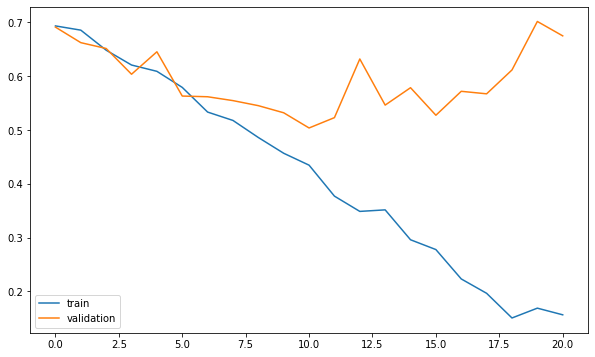

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(hist.epoch, hist.history['loss'], label='train')
plt.plot(hist.epoch, hist.history['val_loss'], label='validation')
plt.legend()
plt.show()

##### 저장된 모델 조회

In [ ]:
# 모델 생성
saved_model1 = get_model()
saved_model1.evaluate(test_iter)

10/10 [==============================] - 4s 370ms/step - loss: 0.6929 - accuracy: 0.5030


[0.6929490566253662, 0.503000020980835]

In [ ]:
# 생성된 모델에 저장된 파라미터 덮어씌우기
saved_model1.load_weights(save_weight_path)
saved_model1.evaluate(test_iter)

10/10 [==============================] - 4s 367ms/step - loss: 0.5076 - accuracy: 0.7540


[0.5076375007629395, 0.7540000081062317]

In [ ]:
-np.log(0.6) # 위의 모델을 보았을 때 성능이 그렇게 까지 좋지는 않다 -> 거의 10%의 확신 (loss와 비교)

0.5108256237659907

# 새로운 데이터 추론

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_preprocessing(image_path):
  """
  경로의 이미지를 읽어서 전처리(scaling) 한 뒤 변환
  """
  raw_img = load_img(image_path, target_size=(224, 224)) # Pillow image 객체로 읽어오기, target_size를 설정하면 resize해서 읽어오기기
  img_array = img_to_array(raw_img)
  img_array = img_array[np.newaxis, ...] # batch 축 늘리기 (224, 224, 3) -> (1, 224, 224, 3)
  img_array = img_array.astype('float32')/255 # float 타입으로 변환 후 255로 나눠서 scaling
  return img_array

In [ ]:

new_img_path = '/content/colab/MyDrive/Colab Notebooks/PlayData/07. Deep Learning/new_data/dog_01.jpg'
new_X = load_preprocessing(new_img_path)

pred = saved_model1.predict(new_X)
print(pred)
print(np.where(pred>=0.5, '개', '고양이'))

1/1 [==============================] - 0s 36ms/step
[[0.9508956]]
[['개']]


# Image data augmentation 사용

- 학습 이미지의 수가 적어서 overfitting이 발생할 가능성을 줄이기 위해 기존 훈련 데이터로부터 그럴듯하게 이미지 변환을 통해서 이미지(데이터)를 늘리는 작업을 Image augmentation
- train_set에만 적용, validation, test set에는 적용하지 않는다. (rescaling만 한다.)

##### 앞 코드에서 모델 생성 & load_preprocessing 함수 까지 실행

##### ImageDataGenerator 생성

In [ ]:
# 데이터셋 디렉토리 경로
trainset_dir = 'data/cats_and_dogs_small/train/'
valset_dir = 'data/cats_and_dogs_small/validation/'
testset_dir = 'data/cats_and_dogs_small/test/'

In [ ]:
# train ImageDataGenerator 생성 => image Augmentation 설정 (train set 에만 설정)
# 너무 많은 옵션을 선택하면 오히려 학습이 잘 안될 수 있다.
train_datagen2 = ImageDataGenerator(rescale=1./255,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    #shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    #vertical_flip=True,
                                    #brightness_range=(0.5, 1.5),
                                    fill_mode='constant')

val_datagen2 = ImageDataGenerator(rescale=1./255)
test_datagen2 = ImageDataGenerator(rescale=1./255)

In [ ]:
train_iter2 = train_datagen2.flow_from_directory(trainset_dir, target_size=(224, 224), class_mode='binary', batch_size=N_BATCH)

val_iter2 = val_datagen2.flow_from_directory(valset_dir, target_size=(224, 224), class_mode='binary', batch_size=N_BATCH)

test_iter2 = test_datagen2.flow_from_directory(testset_dir, target_size=(224, 224), class_mode='binary', batch_size=N_BATCH)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


##### 모델 생성, 컴파일, 학습

In [ ]:
g_drive_path = '/content/colab/MyDrive/Colab Notebooks/PlayData/07. Deep Learning'
save_dir_path = os.path.join(g_drive_path, 'saved_model', 'cat_dog_model_aug') # model 저장 경로 (model+파라미터)
mc_callback2 = keras.callbacks.ModelCheckpoint(save_dir_path, save_best_only=True, monitor='val_loss', verbose=1)
es_callback2 = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)

model2 = get_model()
hist2 = model2.fit(train_iter2, epochs=N_EPOCH,
                   steps_per_epoch = len(train_iter2), # imageDataGenerator는 데이터를 무한제공하기 때문에 1 epoch가 언제 끝나는 지를 알수 없다 -> steps_per_epoch/ validation_steps에 1 epoch이 몇 step인지를 설정해서 직접 알려줘야 한다.
                   validation_data = val_iter2,
                   validation_steps = len(val_iter2),
                   callbacks=[mc_callback2, es_callback2])

##### 저장된 모델 Loading 후 평가(사용)

In [4]:
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import load_img, img_to_array

saved_model2 = models.load_model('saved_model/cat_dog_model_aug')

##### 새로운데이터 추론

In [6]:
import numpy as np

def load_preprocessing_image(path):
    raw_img = load_img(path, target_size=(224, 224)) # 이미지 읽어오기
    img_array = img_to_array(raw_img)
    img_array = img_array[np.newaxis, ...]
    img_array = img_array.astype('float32')/255
    return img_array

In [17]:
img_path = 'new_data/dog_02.jpg'
data = load_preprocessing_image(img_path)
# data.shape
pred = saved_model2.predict(data)
pred_label = np.where(pred[0]>=0.5, '개', '고양이')
print(pred, pred_label)

1/1 [==============================] - 0s 66ms/step
[[0.65367043]] ['개']


In [18]:
saved_model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 28, 28, 128)     